# Neural Network with the Olivetti database

In [1]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # plotting routines
import keras
from keras.models import Model       # Model type to be used
from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL.Image import *
import cv2

## Split dataset definition

In [2]:
def split_dataset(dataset, attribut):
  '''
  Split the dataset into train and test, in order to train the neural network

  Args :
    pixel (array) : X, the photo represented by a 64x64 matrix, each element containing 3 values (a RGB-coded pixel)
    attributs (array) : Y, case Olivetti db : name of the photo, ex : 00000 ; 11111 ; 22222 etc
    
  Returns :
    X_train (array) : portion of the db used to train the neural network - input
    X_test (array) : portion of the db used to test the neural network - output
    Y_train (array) : portion of the db used to train the neural network - input
    Y_test (array) : portion of the db used to test the neural network - output

  >>> dataX = np.zeros(1000)
  >>> dataY = np.ones(1000)
  >>> (X_TR, X_TE, Y_TR, Y_TE) = split_dataset(dataX,dataY)
  >>> X_TR.size == Y_TR.size == 1000*0.8
  True

  >>> X_TE.size == Y_TE.size == 1000*0.2
  True
  
    
  '''
  X_train, X_test, Y_train, Y_test = train_test_split(dataset, attribut, test_size=0.2, random_state=0)
  return X_train, X_test, Y_train, Y_test

## Model definition

In [3]:
def model(original_dim, hidden_encoding_dim, encoding_dim,
           dropout_level, hidden_decoding_dim):
  '''
  Model of neural network

  Args :
    original_dim (int) :
    hidden_encoding_dim (int) :
    encoding_dim (int) :
    dropout_level (float) :
    hidden_decoding_dim (int) :
  Returns :
    encoder (keras.engine.functional.Functional) :
    decoder (keras.engine.functional.Functional) :
    autoencoder (keras.engine.functional.Functional) :

  >>> type(encoder); type(decoder); type(autoencoder);
  <keras.engine.functional.Functional>
  >>> Verify that loss and val loss never reach 0:
      history = autoencoder.history.history
      for i in range(len(history['val_loss'])):
            if history['val_loss'][i]==0:
                print("test failed")
                break
      for i in range(len(history['loss'])):
            if history['loss'][i]==0:
                print("test failed")
                break
  '''
  # "encoded" is the encoded representation of the input
  input_img = keras.Input(shape=(original_dim,))
  hidden_encoded = Dense(hidden_encoding_dim, activation='relu')(input_img)
  dropout_hidden_encoded = Dropout(dropout_level)(hidden_encoded)
  encoded = Dense(encoding_dim, activation='relu')(dropout_hidden_encoded)
  dropout_encoded = Dropout(dropout_level)(encoded)

  # "decoded" is the reconstruction of the input
  hidden_decoded = Dense(hidden_decoding_dim, activation='relu')(dropout_encoded)
  dropout_hidden_decoded = Dropout(dropout_level)(hidden_decoded)
  decoded = Dense(original_dim, activation='sigmoid')(dropout_hidden_decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_img, decoded)
  # This model maps an input to is encoded representation
  encoder = keras.Model(input_img, encoded)
  # This model maps an imput with the same dim as the encoded to the reconstruction
  input_encoded_img = keras.Input(shape=(encoding_dim,))
  hidden_decoder_layer = autoencoder.layers[-3]
  hidden_dropout_decoded_layer = autoencoder.layers[-2]
  decoder_layer = autoencoder.layers[-1]
  decoder = keras.Model(input_encoded_img, decoder_layer(hidden_dropout_decoded_layer(hidden_decoder_layer(input_encoded_img))))

  return encoder, decoder, autoencoder

## Reconstruction plot definition

In [9]:
def save_reconstruction(n,decoded):
  '''
  Save the input images and their reconstruction after being decoded

  Args :
    decoded (array) 
    n (int) : number of faces we will display
  Returns :
    None

  >>> from scipy import misc
  >>> M = misc.imread('img_')
  >>> M.shape
  >>> 
  '''
  for i in range(n):
    plt.imshow(decoded[i].reshape(64,64))
    plt.axis('off')
    plt.gray()
    j=i+1
    #plt.savefig("son/"+str(j)+".png")
    plt.savefig(str(j)+".png")

    #img_=cv2.imread("son/"+str(j)+".png")
    img_=cv2.imread(str(j)+".png")
    img_2=cv2.resize(img_,(100,100))
    #print(img_2)
    #cv2.imwrite('son/'+str(j)+'.png', img_2)
    cv2.imwrite(str(j)+'.png', img_2)

  return None


## Plot the learning curve to test the model

In [5]:
def loss_test(autoencoder):
    '''
    Save the input images and their reconstruction after being decoded

    Args :
        autoencoder(keras.engine.functional.Functional)
    Returns :
        None

    >>> epochs=300 #parameters of autoencoder_.fit(...)
        history['val_loss']==epochs
        <True>
        history['loss']==epochs
        <True>
    '''
    history = autoencoder.history.history
    plt.plot(history['val_loss'],label="test")
    plt.plot(history['loss'],label="training")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()
    return None

## Main

In [7]:
if __name__ == "__main__" :

    # Upload photos and attributes
    from sklearn.datasets import fetch_olivetti_faces # Olivetti faces dataset
    dataset = fetch_olivetti_faces()
    X = dataset["data"]
    y = dataset["target"]

    # Split the dataset
    (X_train_, X_test_, y_train_, y_test_) = split_dataset(X, y)

    # Creation of the model
    original_dim = X.shape[1]
    hidden_encoding_dim = 512
    encoding_dim = 64
    hidden_decoding_dim = 512
    dropout_level = 0.1
    (encoder_, decoder_, autoencoder_) = model (original_dim,
                                                hidden_encoding_dim, encoding_dim,
                                                dropout_level, hidden_decoding_dim)

    # Compile the model
    autoencoder_.compile(optimizer='adam', loss='binary_crossentropy')

    # Fit the model
    autoencoder_.fit(X_train_, X_train_,
                    epochs=300,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(X_test_, X_test_))


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Epoch 1/300
5/5 [==============================] - 3s 184ms/step - loss: 0.6867 - val_loss: 0.6699
Epoch 2/300
5/5 [==============================] - 1s 125ms/step - loss: 0.6705 - val_loss: 0.6679
Epoch 3/300
5/5 [==============================] - 1s 102ms/step - loss: 0.6682 - val_loss: 0.6660
Epoch 4/300
5/5 [==============================] - 1s 125ms/step - loss: 0.6667 - val_loss: 0.6649
Epoch 5/300
5/5 [==============================] - 1s 122ms/step - loss: 0.6657 - val_loss: 0.6645
Epoch 6/300
5/5 [==============================] - 1s 118ms/step - loss: 0.6651 - val_loss: 0.6638
Epoch 7/300
5/5 [==============================] - 1s 146ms/step - loss: 0.6648 - val_loss: 0.6639
Epoch 8/300
5/5 [==============================] - 1s 108ms/step - loss: 0.6641 - val_loss: 0.6633
Epoch 9/300
5/5 [==============================] - 1s 110ms/step - loss: 0.6635 - val_loss: 0.6620
Epo

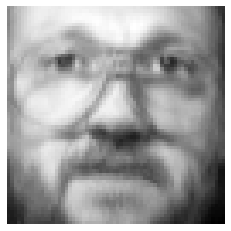

In [10]:
# Plot reconstruction
encoded_imgs = encoder_.predict(X_test_)
decoded_imgs = decoder_.predict(encoded_imgs)
save_reconstruction(1, decoded_imgs)

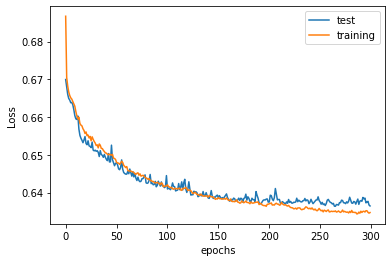

In [11]:
# Plot the learning curve to test the model
loss_test(autoencoder_)

In [ ]:
# save model
np.save('encoded_imgs', encoded_imgs)
np.save('decoded_imgs', decoded_imgs)
decoder_.save('decoder.h5')

np.save('encoded_imgs.npy', encoded_imgs)
np.save('decoded_imgs.npy', decoded_imgs)

In [ ]:
# load model
savedDecoder=load_model('decoder.h5')
savedDecoder.summary()

encoded_imgs = np.load('encoded_imgs.npy')